In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')    #suppress warnings
plt.rc('savefig', dpi=300)
plt.rcParams['animation.embed_limit'] = 2**2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


######################################################################################
# 1) Potential functions 
######################################################################################

    This fonction replaces any mathematical expression that is usually used but that is incorect in python.

    Parameters:
    ----------
        potential (str) : a string that indicates the mathematical form of the potential

    Returns:
    --------
        potential (str) : a new potential that now has changed any mathematical expression 
        that is usually used but that is incorrect in python
        For instance:
            x^2 -> x**2
            |x| -> math.fabs(x)

In [2]:
def ModifyPotential(potential):
    potential = potential.replace('^','**')    #Relacing exponential
    pot_list = potential.rsplit('|') #Replacing absolute value
    for i in [ i for i in range(1,(len(pot_list)-1)*2) if i%2==1 ]:
        insertion = 'np.absolute(' if i%4 ==1 else ')'
        pot_list.insert(i,insertion)
    potential=''.join(pot_list)
    #Replacing trigonometric functions
    potential = potential.replace('cos','np.cos')
    potential = potential.replace('sin','np.sin')
    potential = potential.replace('tan','np.tan')
    return potential

  """ Verify if the potential entered has an invalid syntax and demands another potential untils there is no more syntax error

    Parameters:
    -----------
        potential (str) : a string that indicates the mathematical form of the potential

    Returns:
    --------
        potential (str) : a new string with a valid python mathematical syntax

    """

In [3]:
def VerifySyntaxPotential(potential):
    i=0
    while i == 0:
        try:
            x=0
            eval(potential)
        except SyntaxError:
            potential = input('The potential\'s syntax is incorrect enter a new one: ')
            potential = ModifyPotential(potential)
        else:
            i=1
    return potential

   """Verify if the potential seems to verify the borders conditions (to allow bound states). If it doesn't it ask to the user if he is sure that the potential respects these conditions

    Parameters:
    -----------
        potential (str) : a string that indicates the mathematical form of the potential

    Returns:
    --------
        potential (str) : a new string with a valid python mathematical syntax and with value bigger than V(x=0) for x=-100 and x=100


In [4]:
def VerifyLimitsPotential(potential):
    i=1
    while i == 1:
        eval_pot = list()
        x=-100
        eval_pot.append(eval(potential))
        x=100
        eval_pot.append(eval(potential))
        eval_pot = np.array(eval_pot)
        x = 0
        if eval_pot[eval_pot < eval(potential)]:
            QuestionPotential = input('The potential doesn\'t seem to be correct. Are you it corresponds to a bound state (y/n)? ')

            if QuestionPotential == 'n':
                potential = input('Enter a new potential: ')
                potential = ModifyPotential(potential)                #Check the syntax for the new potential
                potential = VerifySyntaxPotential(potential)
            elif QuestionPotential == 'y':
                i = 0
        else :
                i = 0
    return potential

   """Defines the first energy level as a value between the the average potential and the minimum value. More explicitly: (1/50000)*((V_average + V_min)/2)


    Parameters:
    -----------
        PotentialArray (numpy.ndarray) : a numpy array that contains the potential value between 'x_V_min' and 'x_V_max' at every interval of length 'Division'

    Returns:
    --------
        First_E_guess (float) : the first energy guess that will be used in the Numerov algorithm. It correponds to the average of the minimum value of the potential and the average of the
                                potential times 1/50000

    """

In [5]:
def GetFirstEnergyGuess(PotentialArray):
    First_E_guess = PotentialArray.min() +  (1/500000) * (PotentialArray.mean() + PotentialArray.min())
    return First_E_guess

    """Evaluates the concavity of the potential and returns its value: positive if the concavity is correct or negative if it is incorrect. To be positive, the smallest meeting
    point of an energy guess with the potential needs to have a negative derivative and the greatest meeting point needs to have a positive one. If the function finds no meeting point
    then tries a smaller energy guess and restarts the process


    Parameters:
    -----------
        PotentialArray (numpy.ndarray) : a numpy array that contains the potential value between 'x_V_min' and 'x_V_max' at every interval of length 'Division'
        First_E_guess (float) : the first energy guess that will be used in the Numerov algorithm

    Returns:
    --------
        concavity (str) : a string that indicates the global concavity of the potential. It can either be positive if it respects the condition or negative if it doesn't

    """

In [6]:
def VerifyConcavity(PotentialArray, First_E_guess):
    i = 1
    while i == 1:    #Continue while it doesn't find meeting points
        #print('First Energy guess:', First_E_guess)
        index_min=list()
        index_max=list()
        try:
            for i in range(0,len(PotentialArray)-2):
                if PotentialArray[i] > First_E_guess and PotentialArray[i+1] < First_E_guess:
                    index_min.append(i)
                elif PotentialArray[i] < First_E_guess and PotentialArray[i+1] > First_E_guess:
                    index_max.append(i)
                elif PotentialArray[i] == First_E_guess:
                    if PotentialArray[i-1] > First_E_guess and PotentialArray[i+1] < First_E_guess:
                        index_min.append(i)
                    elif PotentialArray[i-1] < First_E_guess and PotentialArray[i+1] > First_E_guess:
                        index_max.append(i)
                        
            #Defines the concavity value depending on
            #print('index max: ',index_max)
            #print('index_min: ',index_min)
            if (max(index_max) > max(index_min)) and (min(index_max) > min(index_min)):
                concavity = 'positive'
            else:
                concavity = 'negative'
        except ValueError:
            First_E_guess = First_E_guess/2
        else:        #If it is able to compare them, exit the loop
            i = 0
    return concavity,First_E_guess

    """Defines a function that evaluate the potential at a certain point x. This function will be vectorized with np.vectorize to evaluate the potential on a list of position [x1,x2,...]

    Parameters:
    -----------
        position (float) : a float that defines the x position where we want to evaluate the potential
        potential (str) : a string that defines the mathematical expression of the potential

    Returns:
    --------
        EvalPotential (float) : the potential value at the x position

    """

In [7]:
def EvaluateOnePotential(position,potential):
    x = position
    EvalPotential = eval(potential)
    return EvalPotential

   """Checks approximately where the minimum of the potential is and outputs the necessary translation in x and y to recenter the minimum at x=0 and y=0

    Parameters:
    -----------
        potential (str) : a string that defines the mathematical expression of the potential

    Returns:
    --------
        trans_x (float) : the necessary x translation to replace the minimum of the potential at x=0
        trans_y (float) : the necessary y translation to be sure that all the potential values are positive

    """

In [8]:
def TranslationPotential(PositionPotential, PotentialArray):
    # i) Gets the minimum value for the potential and the translation in y
    trans_y = PotentialArray.min()
    #index = float(np.where(PotentialArray==trans_y)[0])

    # ii) Defines the necessary translation in x
    #trans_x = x_min + (Div * index)
    #trans_x = PositionPotential[index]

    # iii) Translates the potential
    PotentialArray = PotentialArray - trans_y
    #PositionPotential = PositionPotential - trans_x
    #print('trans_x; ',trans_x)
    #print('trans_y; ',trans_y)
    return PositionPotential, PotentialArray

def TranslatePotential(potential,trans_x,trans_y):
    '''Modify the potential expression to center its minimum at x=0 and y=0'''
    #x translation
    #potential = potential.replace('x','(x+' + str(trans_x) + ')')
    #y translation
    potential = potential + '-' +  str(trans_y)
    #print(potential)
    return potential

##################################################
# 2) Numerov algorithm functions
##################################################
#########################
# i) Initial Energy guess
    """Defines the energy guess depending on the energy levels that have been found and on the energy that have already been guessed.

    Parameters:
    -----------
        EnergyLevelFound (Dict) : a string that defines the mathematical expression of the potential
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}
        iteration (int) : the number of iteration in the Numerov algorithm
        First_E_guess (float) : the first energy guess. Has been defined preivously.

    Returns:
    --------
        E_guess (float) : the energy guess that will be used in the current Numerov algorithm iteration. We always want to find the smallest energy level that hasn't been discovered yet, so
                          we define it with the previous energy guess that have been made (with E_guess_try).

    """

In [9]:
def E_Guess(EnergyLevelFound, E_guess_try, iteration, First_E_guess):
    #print('Iteration: ',iteration)

    #If it is the first time, return the first energy level of the quantum harmonic oscillator
    if iteration == 1:
        E_guess = First_E_guess  #Takes as intial guess the First_E_guess that has previously been defined
        return E_guess

    # I) Define the energy level that we want to find E_level_guess (the lowest energy level that hasn't been found yet)
    # List for the energy that have been found
    Lvl_found = list(EnergyLevelFound.keys())
    Lvl_found.sort()
    #Gets the energy level that we want to find
    E_level_missing = [index for index,Energy in enumerate(Lvl_found) if not Energy <= index]
    if not E_level_missing:
        if not Lvl_found:
            E_level_guess = 0
        else:
            E_level_guess = max(Lvl_found) +1
    else:
        E_level_guess = min(E_level_missing)

    # II) Defining the energy guess depending on the guess that have already been done (E_guess_try)
    # Finds the closest energy energy level (number of nodes) that has been guessed 
    # and that corresponds to a smaller or an equal number of nodes than E_level_guess
    try:
        E_level_smaller = max([ E for E in E_guess_try.keys() if E <= E_level_guess ])
    except ValueError:
        E_level_smaller = None
    #Finds the closest energy energy level (number of nodes) that has been guessed 
    # and that corresponds to a bigger number of nodes than E_level_guess
    try:
        E_level_bigger = min([ E for E in E_guess_try.keys() if E > E_level_guess ])
    except ValueError:
        E_level_bigger = None

    #Define the energy guess
    #If the smaller and higher exist take the average
    if (not E_level_smaller == None) and (not E_level_bigger ==None):
        E_guess = ( E_guess_try[E_level_smaller][1] + E_guess_try[E_level_bigger][0] ) / 2

    #If only the higher exists take the half
    elif not E_level_bigger == None:
        E_guess = E_guess_try[E_level_bigger][0]/2

    #If only the smaller exists take the double
    elif not E_level_smaller == None:
        E_guess = E_guess_try[E_level_smaller][1] * 2

    #print('E_level_guess:', E_level_guess )
    #print('E_level_bigger: ', E_level_bigger)
    #print('E_level_smaller: ', E_level_smaller)

    return E_guess

##################################################################################
# ii) Setting the minimal and maximal points (where the wave function equals zero)

    """Finds the minimal and maximal points where the energy that has been guessed is equal to the potential.

    Parameters:
    -----------
        E_guess (float) : the guessed energy
        PotentialArray (numpy.darray) : a Numpy array that contains the potential for certain points
        PositionPotential (numpy.darray) : a Numpy array that contains the positions that correspond to the potential array

    Returns:
    --------
        MeetingPoints (tuple) : a tuple of the smallest and biggest meeting point that has th form (Position_min, Position_max)
        end_program (bool) : a boolean that defines if we have to exits the Numerov while loop. end _program is true if we have made ten energy guess and still haven't found
                             two meeting points and is false otherwise.

    """

In [10]:
def MeetingPointsPotential(E_guess, PotentialArray, PositionPotential, E_guess_try):
    #Initializing constant for the while loop
    p = 1
    iteration = 0
    end_program = False

    while p == 1:
        #Finds all the meeting points
        MeetingPoints = [None,None]
        for i in range(0,len(PotentialArray)-2):
            #Gets all the meeting points
            if (PotentialArray[i] < E_guess and PotentialArray[i+1] > E_guess) or (PotentialArray[i] > E_guess and PotentialArray[i+1] < E_guess) or (PotentialArray[i] == E_guess):
                #And filter them
                if (MeetingPoints[0] == None) or (PositionPotential[i] < MeetingPoints[0]):
                    #print('index rencontre min: ',i)
                    MeetingPoints[0] = PositionPotential[i]
                elif (MeetingPoints[1] == None) or (PositionPotential[i] > MeetingPoints[1]):
                    MeetingPoints[1] = PositionPotential[i]
                    #print('index renccontre max: ', i)

        #If we have not found at least two meeting points, then make a new smaller energy guess 
        # and repeat for at most ten times
        if (MeetingPoints[0] == None) or (MeetingPoints[1] == None):
            #print('Restting the energy guess!\n')
            E_guess = (E_guess + max([k for j,k in E_guess_try.values() if k < E_guess]))/2
            iteration += 1
            #print('E_guess: ',E_guess)
            if iteration > 10:
                end_program = True
                break
        else:
            p = 0
            MeetingPoints = tuple(MeetingPoints)

    return MeetingPoints,end_program,E_guess

    """This function determines the minimal and maximal position where the wave function will be set to 0 depending on the points where the potential meets the guess energy and on
    the minimum and maximum that are initially set for the potential.

    Parameter:
    ----------
        MeetingPoints (tuple) : the minimum and maximum point where the potentil meets the guessed energy
        E_guess (float) : The minimum value of the position for the potential
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}
        PotentialArray (numpy.darray) : a Numpy array that contains the potential for certain points
        PositionPotential (numpy.darray) : a Numpy array that contains the positions that correspond to the potential array

    Returns:
    --------
        Position_min (float) : the minimum value where psi=0
        Position_max (float) : the maximum value where psi=0

    """

In [11]:
def DetermineMinAndMax(MeetingPoints):
    #Sets the min and max as the half of the distance between the min and the max plus the min or the max
    Position_min = MeetingPoints[0] - (MeetingPoints[1] - MeetingPoints[0])/1
    Position_max =  MeetingPoints[1] + (MeetingPoints[1] - MeetingPoints[0])/1

    return Position_min,Position_max

#######################################
# iii) Calculate the wave function

    """This function calculates the wave function values depending on the x coordinate by using the Numerov method. The function returns a list that contains tuple with the x coordinate and
    the wave function value.

    Parameter:
    ----------
        potential (str) : a string that defines the mathematical form of the potential
        nbr_division (int) : defines the number of division in the wave function, wich is equivalent to the number of iteration to be made
        Initial_augmentation (float) : Defines the initial augmentation after the minimal x point where the wave function is set to zero
        Position_min : the minimum value where psi=0
        Position_max : the maximum value where psi=0

    Returns:
    --------
        WaveFunction (list) : Defines the wave function. Has the general form: [(x0, psi(x0)), (x1, psi(x1)), ...]

    """

In [12]:
def WaveFunctionNumerov(potential, E_guess, nbr_division, Initial_augmentation, Position_min, Position_max):
    #Initializing the wave function
    WaveFunction = []

    #Setting the divisions
    Division = (Position_max - Position_min) / nbr_division

    #Setting the first values of the wave function
    WaveFunction.append((float(Position_min),0))
    WaveFunction.append((float(Position_min+Division), Initial_augmentation))

    #Defing an array and an index to use in the for loop
    index = 0
    PositionArray = np.arange(Position_min, Position_max, Division)

    #Calculating the wave function for other values
    for i in np.arange(Position_min + (2 * Division), Position_max, Division):
        #Evaluating the potential
        #For V_i+1
        x = i
        V_plus1 = eval(potential)

        #For V_i
        x = PositionArray[index+1]
        V = eval(potential)

        #For V_i-1
        x = PositionArray[index]
        V_minus1 = eval(potential)

        #Setting the k**2 values ( where k**2 = (2m/HBar)*(E-V(x)) )
        k_2_plus1 = 2 * (E_guess - V_plus1)
        k_2 = 2 * (E_guess - V)
        k_2_minus1 = 2 * (E_guess - V_minus1)

        #Calculating the wave function
        psi = ((2 * (1 - (5/12) * (Division**2) * (k_2)) * (WaveFunction[-1][1])) - (1 + (1/12) * (Division**2) * k_2_minus1 ) * (WaveFunction[-2][1])) / (1 + (1/12) * (Division**2) * k_2_plus1)

        #Saving the wave function and the x coordinate
        WaveFunction.append((i,psi))

        #Incrementing the index
        index += 1

    return WaveFunction


########################################################
# iv) Determine the number of nodes in the wave function

    """This function evaluates the number of nodes in the wavefunction. The number of nodes will allow us the determine the energy level to which a certain wave function corresponds.

    Parameter:
    ----------
        WaveFunction (list) : Defines the wave function. Has the general form: [(x0, psi(x0)), (x1, psi(x1)), ...]

    Returns:
    --------
        NumerberOfNodes (int) : Defines the number of nodes in the wave function (the number of time this function passed by the x axis). The number of nodes in a wave funtion
                                corresponds to the energy level of that wave function
        PositionNodes (list) : Defines the x position of all the nodes. Has the form : [position_nodes_1, position_nodes_2, ...]
        x_max (float) : the greatest position of a node. Corresponds to the maximum value of PositionNodes

    """

In [13]:
def NumberNodes(WaveFunction):
    #Initialize the number of nodes and their position
    NumberOfNodes = 0
    PositionNodes = list()

    #Calculate the number of nodes
    for i in range(1,len(WaveFunction)-1):
        if (WaveFunction[i][1] > 0 and WaveFunction[i+1][1] < 0) or (WaveFunction[i][1] < 0 and WaveFunction[i+1][1] > 0) or (WaveFunction[i][1] == 0):
            NumberOfNodes += 1
            PositionNodes.append(WaveFunction[i][0])


    #Gets the biggest position
    x = list()
    for position,wave in WaveFunction:
        x.append(position)
    x_max = max(x)

    return NumberOfNodes,PositionNodes,x_max

#####################################################
# v) Verify if wave function respects the restriction

    """See if the wave function for the given energy level respects the tolerance. The tolerance is defined in the parameters of the Numerov.py script. The tolerance is respected
    if the last value of the wave function is smaller than this tolerance or if two energy guess are very very close (ratio of 0.9999999999). The function return yes in this case
    and no otherwise.

    Parameter:
    ----------
        WaveFunction (list) : Defines the wave function. Has the general form: [(x0, psi(x0)), (x1, psi(x1)), ...]
        Tolerance (float) : Defines the tolerance wich the wave function must respect
        E_guess (float) : The minimum value of the position for the potential
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}
        NumerberOfNodes (int) : Defines the number of nodes in the wave function (the number of time this function passed by the x axis). The number of nodes in a wave funtion
                                corresponds to the energy level of that wave function

    Returns:
    --------
        VerificationTolerance (str) : defines if the wave function respects the condition. Has the value 'yes' if it resects them and 'no' otherwise

    """

In [14]:
def VerifyTolerance(WaveFunction, Tolerance, E_guess, E_guess_try, NumberOfNodes):

    # i) Checks if the last value of the wave function respects the tolerance
    VerificationTolerance = 'yes' if np.absolute(WaveFunction[-1][1]) < Tolerance else 'no'
    #print('Last value Wave Function: ', WaveFunction[-1][1])

    # ii) Checks if the energy guess doesn't change a lot
    try:
        E_minus = E_guess_try[NumberOfNodes][1]
        E_plus = E_guess_try[NumberOfNodes + 1][0]
    except KeyError:
        pass
    else:
        if (E_guess < E_plus and E_guess > E_minus) and ((E_minus/E_plus) > 0.9999999999) :
            VerificationTolerance = 'yes'

    return VerificationTolerance

    """This function corrects the number of nodes. So it removes a node if it is too close to the maximum value where \psi(x) is set to zero or if the E_guess doesn't correspond the the
    energy levels defined by the number of nodes.

    Parameter:
    ----------
        NumerberOfNodes (int) : Defines the number of nodes in the wave function (the number of time this function passed by the x axis). The number of nodes in a wave funtion
                                corresponds to the energy level of that wave function
        PositionNodes (list) : Defines the x position of all the nodes. Has the form : [position_nodes_1, position_nodes_2, ...]
        x_max (float) : the greatest position of a node. Corresponds to the maximum value of PositionNodes
        E_guess (float) : The minimum value of the position for the potential
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}

    Returns:
    --------
        NumberOfNodesCorrected(int) : the corrected number of nodes

    """


In [15]:
def CorrectNodeNumber(NumberOfNodes, PositionNodes, x_max, E_guess, E_guess_try):
    NumberOfNodesCorrected = NumberOfNodes
    #Correct the number of nodes if E_guess is between the lowest energy for this number of nodes and the maximum for the number of nodes - 1
    try:
        if (E_guess_try[NumberOfNodes][1] > E_guess) and (E_guess_try[NumberOfNodes - 1][1] < E_guess):
            NumberOfNodesCorrected -= 1
    #If the dictionnary E_guess_try doesn't contain these keys check if the Last number of nodes is close to the maximum value in x x_max
    except KeyError:
        if (PositionNodes/x_max) > 94:
            NumberOfNodesCorrected -= 1

    return NumberOfNodesCorrected




#######################################################
# vi) Saves energy and the correponding number of nodes

    """This function saves the guessed energy and the number of nodes corresponding to it.

    Parameter:
    ----------
        NumerberOfNodes (int) : Defines the number of nodes in the wave function (the number of time this function passed by the x axis). The number of nodes in a wave funtion
                                corresponds to the energy level of that wave function
        E_guess (float) : The minimum value of the position for the potential
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}

    Returns:
    --------
        E_guess_try (Dict) : a dictionnary that contains the previous energy guess. Has the form : {nbr_nodes1:[E_min,E_max], nbr_nodes2:[E_min,E_max],...}

    """

    #Checks if the key Number of Nodes exists. If it doesn't, define the two values in the list corresponding to the key NumberOfNodes as E_guess.
    

In [16]:
def SaveEnergy(NumberOfNodes, E_guess, E_guess_try):
    try:
        E_guess_try[NumberOfNodes]

    except KeyError:
        E_guess_try[NumberOfNodes] = [E_guess, E_guess]
        return E_guess_try

    #Checks if the energy guess is smaller than the smallest value in the list
    if E_guess < E_guess_try[NumberOfNodes][0]:
        E_guess_try[NumberOfNodes][0] = E_guess

    #Checks if the energy guess is greater than the biggest value in the list
    elif E_guess > E_guess_try[NumberOfNodes][1]:
        E_guess_try[NumberOfNodes][1] = E_guess

    return E_guess_try

#####################################
# 3) Ouput (Energy levels and figure)
####################################

    """This functions defines what to plot in the figure with the wave function and the corresponding energy levels.

    Parameter:
    ----------
        E_guess_tr (Dict) : a dictionnary that contains the wave function that respecetd the tolerance. Has the form {nbr_nodes1:WaveFunction1, nbr_nodes2:WaveFunction2, ...}
        EnergyLevelFound (Dict) : a dictionnary that contains the energy guess that respecetd the tolerance. Has the form {nbr_nodes1:E1, nbr_nodes2:E2, ...}

    Returns:
    --------
        y_max (float) : defines the maximum limit in the y axis that will be set. Correspond to 1.1 times the greatest energy level found
        min_x (float) : defines the minium x value of the x axis. Correspond to the smallest x coordinate of all the wave function.
        max_x (float) : defines the maximum x value of the x axis. Correspond to the greatest x coordinate of all the wave function.
        WavPlot (list) : contains tuples that contain the numpy arrays with the x and y coordinates of the wave functions
        WavLines (list) : contains tuples that contain numpy arrays with the x and y array of a line that passes in the middle of the wave function
        EnergyLines (list) : contains tuples that contain numpy arrays with the x and y array of a line that defines an energy level

    """

In [17]:
#############################
# i) ouput the energy levels
def OuputEnergy(EnergyLevelFound):
    for i,Energy in EnergyLevelFound.items():
        print('Energy level', i, ':', Energy)

############################
# ii) Draw the figure

#Define the wave funcions to plot, the lines corresponding to these wave function and the energy lines
def DefineWhatToPlot(WaveFunctionFound, EnergyLevelFound):
    
    # i) Determine the maximum energy to set the maximum value for the y axis
    y_max = 1.1*EnergyLevelFound[max(EnergyLevelFound)]
    Y_by_E_level = (y_max/(max(EnergyLevelFound)+2))

    # ii) For the wave function
    WavPlot = []
    for i in WaveFunctionFound.keys():
        x=[]
        y=[]
        for j in range(400,len(WaveFunctionFound[i])-240):
            if not (j > 3750 and np.absolute(WaveFunctionFound[i][j][1]) > (max(y)*0.07)):
                x.append(WaveFunctionFound[i][j][0])
                y.append(WaveFunctionFound[i][j][1])
        x = np.array(x)
        y = np.array(y)

        mult = (0.9 * Y_by_E_level)/(2 * y.max())
        y = (mult * y) + (Y_by_E_level * (i+1))
        WavPlot.append((x,y))

    # iii) Determines the min and max in x
    min_x = x.min()
    max_x = x.max()

    # iv) Get lines to where the wave function is centered
    WavLines = []
    for i in WaveFunctionFound.keys():
        Wav_line_y=[]
        for j in range(len(x)):
            Wav_line_y.append(Y_by_E_level * (i+1))
        WavLines.append((x,Wav_line_y))


    # v) get lines for all the Energy levels
    EnergyLines = []
    for i in WaveFunctionFound.keys():
        En_y = []
        for j in range(len(x)):
            En_y.append(EnergyLevelFound[i])
        EnergyLines.append((x,En_y))

    return y_max, min_x, max_x, WavPlot, WavLines, EnergyLines

 """This functions plots a figure with two subplots: the first contains the potential and a line for each energy level and the second contains the potential and
    animation of the real and imaginary part of the wave function (note that the wave function aren't centered at their corresponding energy level but are equally spaced
    for visibility)

    Parameter:
    ----------
        y_max (float) : defines the maximum limit in the y axis that will be set. Correspond to 1.1 times the greatest energy level found
        min_x (float) : defines the minium x value of the x axis. Correspond to the smallest x coordinate of all the wave function.
        max_x (float) : defines the maximum x value of the x axis. Correspond to the greatest x coordinate of all the wave function.
        WavPlot (list) : contains tuples that contain the numpy arrays with the x and y coordinates of the wave functions
        WavLines (list) : contains tuples that contain numpy arrays with the x and y array of a line that passes in the middle of the wave function
        EnergyLines (list) : contains tuples that contain numpy arrays with the x and y array of a line that defines an energy level
        PotentialArray (numpy.darray) : a Numpy array that contains the potential for certain points
        PositionPotential (numpy.darray) : a Numpy array that contains the positions that correspond to the potential array

    Returns:
    --------

    """

In [18]:
#Draw the wave Functions, the energy levels and sets the axis limits
def DrawWaveFunction(y_max, min_x, max_x, WavPlot, WavLines, EnergyLines, PositionPotential, PotentialArray):
   

    ###################################################################################################
    # i) Define a new figure with two subplot: the energy levels and the corresponding wave function
    f,(En,Wav) = plt.subplots(1,2,sharey=True)

    #Set figure title
    f.suptitle("Schrödinger equation solutions",fontsize=20,fontweight='bold',y=1.)


    ################################
    # ii) Draw the wave functions
    lines = [Wav.plot(x,y,'b',label=r"$Re(\psi(x))$",zorder=3)[0] for x,y in WavPlot]
    lines2 =  [Wav.plot(x,y,'m',label=r"$Im(\psi(x))$",zorder=3)[0] for x,y in WavPlot]

    for x,y in WavLines:
        Wav.plot(x,y,'k--',zorder=1)

    #Sets the axis limits
    Wav.axis([min_x, max_x, 0, y_max])

    #Draw the potential
    Wav.plot(PositionPotential, PotentialArray, 'r',label='Potential',zorder=2)


    ################################
    # iii) Draw the Energy levels
    i = 0
    for x,y in EnergyLines:
        PlotColor = cm.viridis(i/len(EnergyLines))
        En.plot(x,y,'--',color=PlotColor,label='E'+str(i),zorder=2)
        i+=1

    #Set the axis limit
    En.axis([min_x, max_x, 0, y_max])

    #Draw the potential
    En.plot(PositionPotential, PotentialArray, 'r',label='Potential',zorder=1)


    ####################################################
    # iv) Sets differents aesthetic components

    #For the wave function set the title and the axis title
    Wav.set_xlabel(r'x ($a_0$)')
    Wav.set_title('Wave Function',fontsize=14)

    #Verify if the labels reappear multiple times and set legend for the wave function
    handles, labels = plt.gca().get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    leg1 = Wav.legend(newHandles, newLabels,bbox_to_anchor=(1.05, 1), loc='lower right', fontsize='x-small')
    leg1.get_frame().set_alpha(1)

    #Identify each wave function
    for i in range(len(EnergyLines)):
        Wav.text(((max_x - min_x) * 0.04) + min_x, WavLines[i][1][0] - (0.25 * (y_max/(len(EnergyLines)+2))),
                 r'$\Psi_{%s}(x)$'%(i))

    #For the energy levels set the title, the axis title and the legend
    En.set_xlabel(r'x ($a_0$)')
    En.set_ylabel('Energy (Hartree)')
    En.set_title('Energy levels',fontsize=14)
    leg2 = En.legend(loc='lower left', fontsize='x-small')
    leg2.get_frame().set_alpha(1)


    #################################
    # v) Animate the wave function

    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    def UpdateData(t):
        for j,line in enumerate(lines):
            x = WavPlot[j][0]
            y = ((WavPlot[j][1] - (WavLines[j][1][0]))  * np.cos(EnergyLines[j][1][0]*t/20)) + (WavLines[j][1][0])
            line.set_data(x,y)
        for j,line in enumerate(lines2):
            x = WavPlot[j][0]
            y = ((WavPlot[j][1] - (WavLines[j][1][0]))  * np.sin(EnergyLines[j][1][0]*t/20)) + (WavLines[j][1][0])
            line.set_data(x,y)

        return lines,lines2
    
    animsho = animation.FuncAnimation(f, UpdateData, init_func=init, interval=10, blit=False, repeat=True, save_count=300,)
     
    #fig = plt.gcf()
    #fig.set_size_inches(15.5, 8.5, forward=True)
    #anim1.save('sho1.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=600)
    animsho.save('scho.gif', writer='pillow', fps=15)
    return HTML(animsho.to_jshtml()) 

###################################
# 4) Numerov algorithm
###################################

## Initializing paramaters for the while loop
EnergyLevelFound = {} **Defines energy levels that avec been found. Has the structure {0:E0, 1:E1, 2:E2, ...}** 

WaveFunctionFound = {} **Defines the wave functions that have been found. Has the structure {0:WaveFunction0, 1:WaveFunction1, ...}**

E_guess_try = {} **Defines the lowest and higest energy levels that have been used so far for each number of nodes. Has the structure {NbrNodes1:[Energy guessed min, Energy guessed max], ...}**

iteration = 1 **Defines the number of iterations**

E_found = list() **A list of the energy levels that have been found (ex: [0,2,3] if the energy levels 0,2 and 3 have been found)**
# Note: All the wave function are a list of tuple and have the following structure: $[(x0, \psi(x0), (x1, \psi(x1)), ...]$

# Continue while we don't have the n first energy level

In [19]:
def Schrodinger(f,E_level):
    x_V_min = -13
    x_V_max = 13
    nbr_division_V = 800000
    nbr_division = 5000
    Initial_augmentation = 0.00001
    Tolerance = 0.00000001
    
    # i) Energy levels
    E_lvl = list(range(0,E_level))

    # ii) Potential
    potential=f   # input

    i=1
    while i == 1:
        potential = ModifyPotential(potential)
        potential = VerifySyntaxPotential(potential)
        potential = VerifyLimitsPotential(potential)
        EvaluatePotential = np.vectorize(EvaluateOnePotential)
        DivisionPotential = (x_V_max - x_V_min) / nbr_division_V
        PositionPotential = np.arange(x_V_min,x_V_max,DivisionPotential)
        PotentialArray = EvaluatePotential(PositionPotential,potential)
        PositionPotential,PotentialArray = TranslationPotential(PositionPotential, PotentialArray)
        First_E_guess = GetFirstEnergyGuess(PotentialArray)
        concavity,First_E_guess = VerifyConcavity(PotentialArray, First_E_guess)
        
        if concavity == 'positive':
            i = 0
        elif concavity == 'negative':
            potential2 = input('The concavity of the potential isn\'t correct enter a new one (or "O" to overule): ')
            if potential2 == 'O':
                i = 0
            else :
                potential = potential2
                
    #Initializing paramaters for the while loop  .
    EnergyLevelFound = {} 
    WaveFunctionFound = {}
    E_guess_try = {} 
    iteration = 1
    E_found = list() 
    while not E_found == list(range(E_level)):
        # i) Initial Energy guess
        E_guess = E_Guess(EnergyLevelFound,E_guess_try,iteration, First_E_guess)
        #print('E_guess: ', E_guess)
        # ii) Setting the initial and final points (where \psi=0)
        # Gets the meeting points with the energy and the potential
        MeetingPoints,end_program,E_guess = MeetingPointsPotential(E_guess, PotentialArray, PositionPotential, E_guess_try)
        if end_program:
            break
        Position_min,Position_max = DetermineMinAndMax(MeetingPoints)
        # iii) Calculate the wave fonction for the guessed energy value
        WaveFunction = WaveFunctionNumerov(potential, E_guess, nbr_division,Initial_augmentation,Position_min,Position_max)
        # iv) Determine the number of nodes in the wave fonction and set the tolerance
        NumberOfNodes,PositionNodes,x_max = NumberNodes(WaveFunction)
        #print('NumberOfNodes:', NumberOfNodes)
        # v) See if the wave fonction for this energy respects the restriction (if yes save)
        VerificationTolerance = VerifyTolerance(WaveFunction,Tolerance,E_guess,E_guess_try,NumberOfNodes)
        if VerificationTolerance == 'yes':
            #print('Niveau d\'energie trouve!!\n\n')
            NumberOfNodesCorrected = CorrectNodeNumber(NumberOfNodes,PositionNodes,x_max,E_guess,E_guess_try)
            EnergyLevelFound.update({NumberOfNodesCorrected:E_guess})
            WaveFunctionFound.update({NumberOfNodesCorrected:WaveFunction})
        # vi) Saves Energy guess and the corresponding number of nodes (no matter if it fails)
        E_guess_try = SaveEnergy(NumberOfNodes, E_guess, E_guess_try)
        #print('E_guess_try: ',E_guess_try)
        #Increments the iteration
        #print('iterations:',iteration,'\n')
        iteration += 1     
        # vii) Updates the Energy levels found list to verify if the condition is respected
        E_found = list()
        for i in EnergyLevelFound.keys():
            E_found.append(i)
        E_found.sort()
        #print('Energy level found',EnergyLevelFound)
        
    OuputEnergy(EnergyLevelFound)    # i) Energy levels
    y_max,min_x,max_x,WavPlot,WavLines,EnergyLines = DefineWhatToPlot(WaveFunctionFound,EnergyLevelFound)
    return DrawWaveFunction(y_max, min_x, max_x, WavPlot, WavLines, EnergyLines, PositionPotential, PotentialArray)   

Energy level 0 : 0.707658207399305
Energy level 1 : 2.1213203443453392
Energy level 2 : 3.535533905899138
Energy level 3 : 4.949747468258793
Energy level 4 : 6.3639610305110015
Energy level 5 : 7.778174592655763
Energy level 6 : 9.192388154585625
Energy level 7 : 10.606601716300595
Energy level 8 : 12.020815277155982


Animation size has reached 4229511 bytes, exceeding the limit of 4194304.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


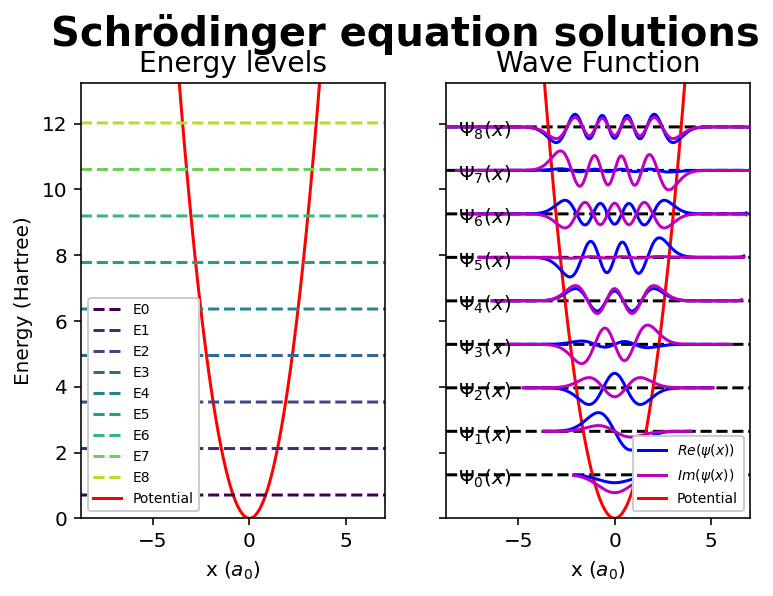

In [20]:
Schrodinger('x**2',9)

Energy level 0 : 0.8163999999898357
Energy level 1 : 1.855757434479558
Energy level 2 : 2.5780958297614354
Energy level 3 : 3.24460762395287
Energy level 4 : 3.825714829686823
Energy level 5 : 4.381671239060057
Energy level 6 : 4.891819712316394
Energy level 7 : 5.386613780062051
Energy level 8 : 5.851300271296796


Animation size has reached 4436617 bytes, exceeding the limit of 4194304.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


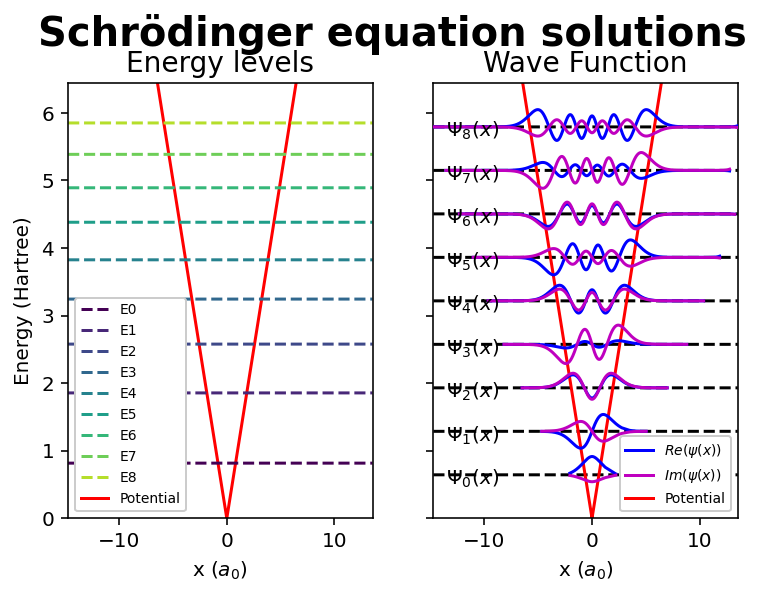

In [21]:
Schrodinger('|x|',9)

In [ ]:
Schrodinger('3*(x^4)-2*(x^3)-6*(x^2)+x+5',4)

In [ ]:
Schrodinger('(x^4)-6*(x^2)+9',7)